In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the file paths
train_files = ['own/data/1.csv', 'own/data/2.csv', 'own/data/5.csv']
validation_test_file = 'own/data/4.csv'

# Function to load and preprocess data
def load_and_preprocess_data(train_files, validation_test_file):
    # Load the training data
    train_dfs = [pd.read_csv(file) for file in train_files]
    
    # Load the validation and test data
    validation_test_df = pd.read_csv(validation_test_file)
    
    # Convert 'date/time' columns to datetime
    for df in train_dfs:
        df['datetime'] = pd.to_datetime(df['date/time'], errors='coerce')
    validation_test_df['datetime'] = pd.to_datetime(validation_test_df['date/time'], errors='coerce')
    
    # Process each training dataframe
    processed_train_dfs = []
    for df, file in zip(train_dfs, train_files):
        if '1.csv' in file:
            # Remove the first 1 minute and the last 3 minutes from the first training data (1.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=1)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=3)
        elif '2.csv' in file:
            # Remove the first 3 minutes and the last 2.5 minutes from the second training data (2.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=3)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=2.5)
        else:
            # Remove the first and last 1.5 minutes from the other training data (4.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=1.5)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=1.5)
        processed_df = df[(df['datetime'] >= train_start_time) & (df['datetime'] <= train_end_time)]
        processed_train_dfs.append(processed_df)
    
    # Concatenate all processed training dataframes
    train_df = pd.concat(processed_train_dfs, ignore_index=True)
    
    # Split validation_test_df into validation and test sets
    mid_index = len(validation_test_df) // 2
    val_df = validation_test_df.iloc[:mid_index]
    test_df = validation_test_df.iloc[mid_index:]
    
    return train_df, val_df, test_df

# Load datasets
train_df, val_df, test_df = load_and_preprocess_data(train_files, validation_test_file)

print('Loading complete')
train_df.head(), val_df.head(), test_df.head()


2024-06-16 23:38:02.166514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 23:38:03.049925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-16 23:38:03.050020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-

Loading complete


(                    date/time     gyro_x    gyro_y    gyro_z   accel_x  \
 0  2024-06-05 14:09:12.810708  47.229008  1.580153  4.488550  0.464475   
 1  2024-06-05 14:09:12.818031  47.030534  0.419847  5.343511 -0.964863   
 2  2024-06-05 14:09:12.824984  47.328244 -4.145038  6.557252 -0.799663   
 3  2024-06-05 14:09:12.832316  48.068702 -3.725191  6.763359  1.841141   
 4  2024-06-05 14:09:12.839155  47.679389 -1.847328  6.595420  3.287239   
 
     accel_y    accel_z          x          y                   timestamp  \
 0  0.493206   7.393295  25.891441  53.151175  2024-06-05 14:09:12.810708   
 1  0.105345   7.541735  25.891441  53.151175  2024-06-05 14:09:12.818031   
 2  0.849942   8.384494  25.891441  53.151175  2024-06-05 14:09:12.824984   
 3  0.289698  10.572795  25.891441  53.151175  2024-06-05 14:09:12.832316   
 4  0.694318  11.298238  25.891441  53.151175  2024-06-05 14:09:12.839155   
 
       x_cam     y_cam     z_cam                   datetime  
 0  0.184902 -0.982724

In [2]:
# Define features and targets
features = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'x_cam', 'y_cam', 'z_cam']
targets = ['x', 'y']

# Scale the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[features])
val_X_scaled = scaler.transform(val_df[features])
test_X_scaled = scaler.transform(test_df[features])

# Extract target values
train_y = train_df[targets].values
val_y = val_df[targets].values
test_y = test_df[targets].values

# Convert the data into sequences
def create_sequences(data, truth, sequence_length=400):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(truth[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 400
X_train, y_train = create_sequences(train_X_scaled, train_y, sequence_length)
X_val, y_val = create_sequences(val_X_scaled, val_y, sequence_length)
X_test, y_test = create_sequences(test_X_scaled, test_y, sequence_length)

print('Input sequences complete')


Input sequences complete


In [3]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2))  # Output layer for the three targets (x, y, z)
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Define input shape based on the training data
input_shape = (sequence_length, len(features))

# Create the model
model = create_model(input_shape)
model.summary()

# Define the checkpoint
checkpoint_filepath = 'trajectory_model12-checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Load weights if checkpoint exists
if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)
    print('Checkpoint loaded.')

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_callback],
                    verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

# Save the model
model.save('trajectory_model12.h5')

print('Model training complete and saved to trajectory_model12.h5')


2024-06-16 23:38:35.790890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: /usr/lib/x86_64-linux-gnu/libcuda.so.1: file too short; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-16 23:38:35.790915: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 100)          44000     
                                                                 
 dropout (Dropout)           (None, 400, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 129,552
Trainable params: 129,552
Non-trai

2024-06-16 23:38:43.639271: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4765449600 exceeds 10% of free system memory.


5171/5171 [==============================] - ETA: 0s - loss: 15.7339
Epoch 1: loss improved from inf to 15.73385, saving model to trajectory_model12-checkpoint.h5
5171/5171 [==============================] - 3281s 634ms/step - loss: 15.7339 - val_loss: 244.4081
Epoch 2/5
5171/5171 [==============================] - ETA: 0s - loss: 19.2637
Epoch 2: loss did not improve from 15.73385
5171/5171 [==============================] - 2584s 500ms/step - loss: 19.2637 - val_loss: 249.1915
Epoch 3/5
5171/5171 [==============================] - ETA: 0s - loss: 12.6323
Epoch 3: loss improved from 15.73385 to 12.63232, saving model to trajectory_model12-checkpoint.h5
5171/5171 [==============================] - 2595s 502ms/step - loss: 12.6323 - val_loss: 265.6033
Epoch 4/5
5171/5171 [==============================] - ETA: 0s - loss: 11.7259
Epoch 4: loss improved from 12.63232 to 11.72587, saving model to trajectory_model12-checkpoint.h5
5171/5171 [==============================] - 2562s 495ms/step

3080/3080 [==============================] - 423s 137ms/step


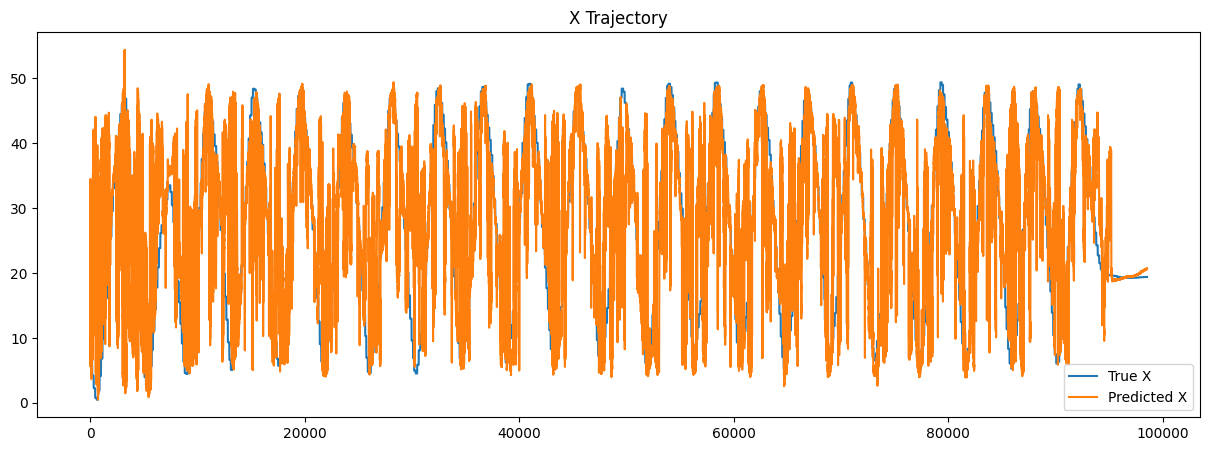

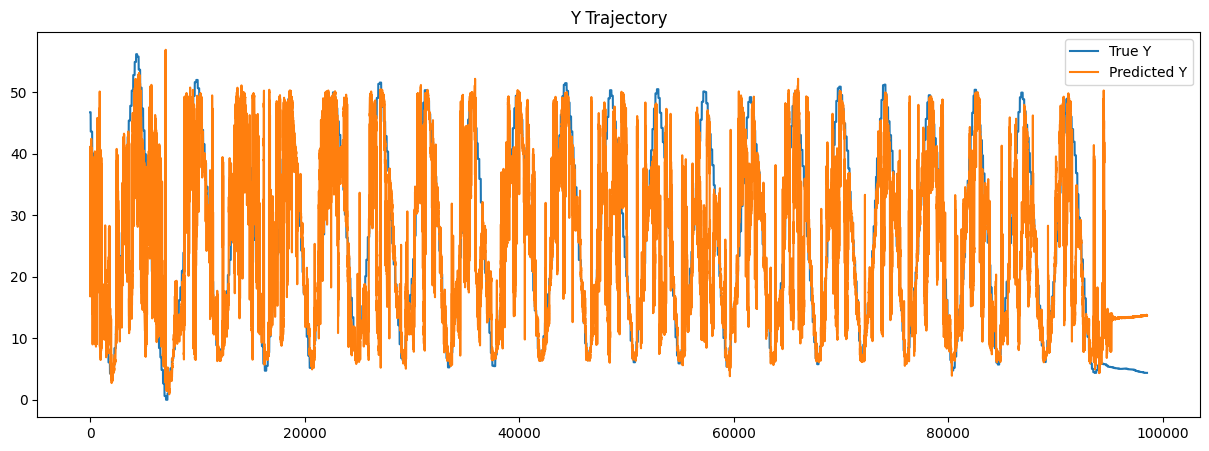

In [4]:
from tensorflow.keras.models import load_model

# Load the model and test it
loaded_model = load_model('trajectory_model12.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

3080/3080 [==============================] - 431s 140ms/step
RMSE before filtering: 11.656403001042124
RMSE after filtering: 10.800780894731336


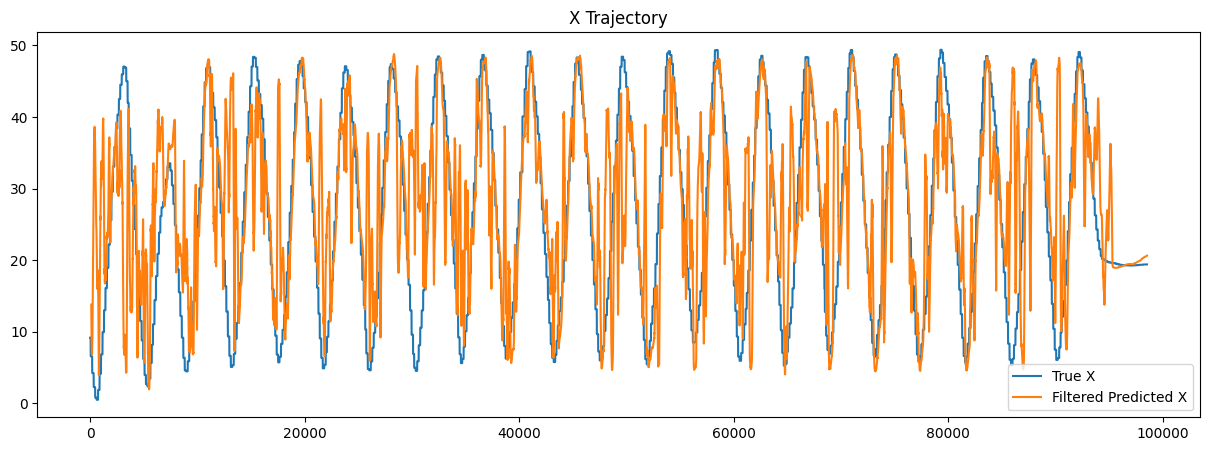

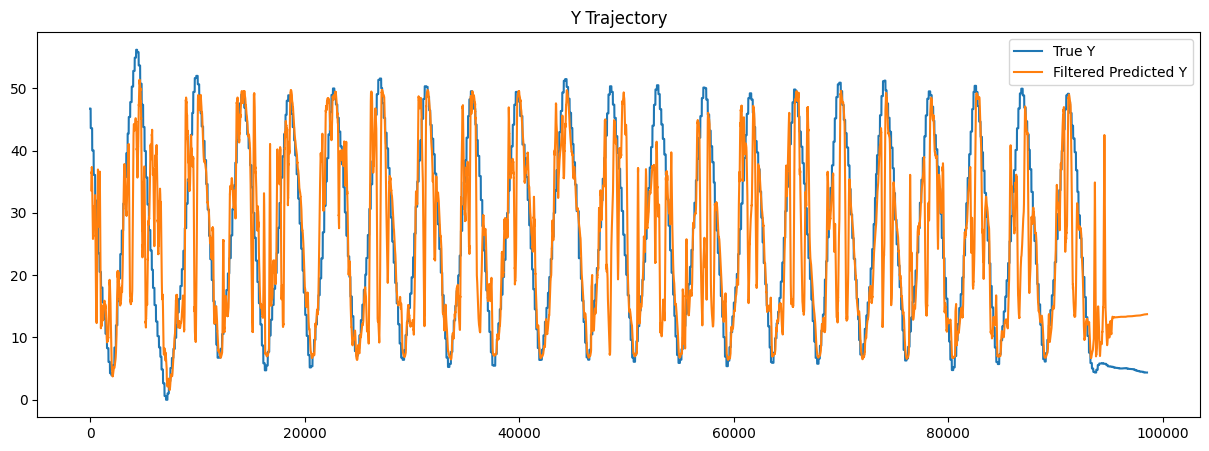

In [5]:
from sklearn.metrics import mean_squared_error
# Load the model and test it
loaded_model = load_model('trajectory_model12.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate the RMSE again after filtering
rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
print(f'RMSE after filtering: {rmse_after_filter}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
#plt.plot(y_pred[:, 0], label='Predicted X')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 0], label='Filtered Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
#plt.plot(y_pred[:, 1], label='Predicted Y')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 1], label='Filtered Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()